In [1]:
pip install regions

Note: you may need to restart the kernel to use updated packages.


## RSGS = firebrick
## WRS = lightskyblue
## SNRS = green

In [2]:
%pylab inline
import pandas as pd
from astropy.io import ascii, fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
import sys
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
style_revisions = {
 'axes.linewidth':  1.5, 
 'xtick.top' : True,         
 'ytick.right' :  True,
 'xtick.direction' : 'in',    
 'ytick.direction' : 'in', 
 'xtick.major.size' : 11,     
 'ytick.major.size' : 11,
 'xtick.minor.size' : 5.5,    
 'ytick.minor.size' : 5.5,      
 'font.size' : 18,              
 'figure.figsize' : [16, 16], 
 'lines.linewidth' : 2.      
}

## Data

In [4]:
comap = fits.open("ico.fits")
comapdata = comap[0].data[0,0]
#size (x,y) of the CO map data array
lencox, lencoy = comapdata.shape
#Filtering -- here we filter out n}ns and any value less than "thresh"
thresh = 0
mask = np.isnan(comapdata) | (comapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
comapdata[mask] = nan
#Get the world coordinates for the CO map
comapheader = comap[0].header
wc = wcs.WCS(comapheader, naxis=2)

In [5]:
comap2 = fits.open("new_COmap.fits")
comapdata2 = comap2[0].data
lenco2x, lenco2y = comapdata2.shape
#Get the world coordinates for the CO map
comapheader2 = comap2[0].header
wc2 = wcs.WCS(comapheader2, naxis=2)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
atomicmap = fits.open("atomic.fits")
atomicmapdata = atomicmap[0].data
#size (x,y) of the atomic map data array
lenatomicx, lenatomicy = atomicmapdata.shape
#Filtering -- here we filter out nans and any value less than "thresh"
thresh = 0
mask = np.isnan(atomicmapdata) | (atomicmapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
atomicmapdata[mask] = nan
#Get the world coordinates for the CO map
atomicmapheader = atomicmap[0].header
wc3 = wcs.WCS(atomicmapheader, naxis=2)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [7]:
wrtab = ascii.read("wr_m33.tsv", data_start=3)
wrcoords = SkyCoord(wrtab["_RA"], wrtab["_DE"], unit="deg")
wrpix = np.asarray(skycoord_to_pixel(wrcoords, wc), dtype=int)
wrpix_insideco = np.array([[i,j] for i,j in wrpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
wrco = comapdata[wrpix_insideco[1], wrpix_insideco[0]]
#Read ASCII table
rsgtab = ascii.read("rsg_m33.tsv", data_start=3)
#Get sky coordinates of RSGs
rsgcoords = SkyCoord(rsgtab["RAJ2000"], rsgtab["DEJ2000"], unit=("hourangle", "deg"))
#Convert sky coordinates to pixels using world coordinate system defined earlier
#np.asarray converts the list into a numpy array with data-type "int". Numpy arrays
#are much easier to manipulate than Python lists
rsgpix = np.asarray(skycoord_to_pixel(rsgcoords, wc), dtype=int)
#Only keep RSG pixels that fall inside the CO map area
#This line below uses the list comprehension trickery of Python! Its the equivalent of writing
rsgpix_insideco = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
rsgco = comapdata[rsgpix_insideco[1], rsgpix_insideco[0]]

In [8]:
#Read ASCII table
snrtab = ascii.read("snrs.tsv", data_start=3)
#Get sky coordinates of snrs
snrcoords = SkyCoord(snrtab["RAJ2000"], snrtab["DEJ2000"], unit=("hourangle", "deg"))
#Convert sky coordinates to pixels using world coordinate system defined earlier
#np.asarray converts the list into a numpy array with data-type "int". Numpy arrays
#are much easier to manipulate than Python lists
snrpix = np.asarray(skycoord_to_pixel(snrcoords, wc), dtype=int)
#Only keep SNR pixels that fall inside the CO map area
#This line below uses the list comprehension trickery of Python! Its the equivalent of writing
snrpix_insideco = np.array([[i,j] for i,j in snrpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T

#Get CO intensity values for the SNR pixels
snrco = comapdata[snrpix_insideco[1], snrpix_insideco[0]]

In [9]:
def get_ncr(data, vals):
    """
    Sets nans equal to 0 in both arrays and returns
    the ncr value
    """
    a = np.nan_to_num(data, copy=True, nan=0.0)
    b = np.nan_to_num(vals, copy=True, nan=0.0)
    a2 = np.sort(a)
    return np.array([np.where(a2>=x)[0][0]/len(a2) for x in b])

## Region

In [10]:
from regions import Regions
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion, PixCoord, CirclePixelRegion
from regions import PixCoord


sky_region = Regions.read('ACAregion_singlepoly.reg', format='ds9')
rsg_skycoords = np.transpose(rsgcoords)
rsg_skycoords2 = np.transpose(rsgcoords)
wr_skycoords = np.transpose(wrcoords)
snr_skycoords = np.transpose(snrcoords)

In [11]:
sky_region

<Regions([<PolygonSkyRegion(vertices=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(23.6754846, 30.8179815), (23.4167034, 30.8648173),
     (23.3110882, 30.5247383), (23.5741699, 30.479219 )]>)>])>

In [12]:
#Getting our new stellar populations; RSGs
arr_is_inside1 = sky_region[0].contains(rsg_skycoords, wc2)
rsgs_inside_box1 = rsg_skycoords[arr_is_inside1]
#arr_is_inside2 = sky_region[1].contains(rsg_skycoords2, wc2)
#rsgs_inside_box2 = rsg_skycoords2[arr_is_inside2]

#WR
arr_is_inside3 = sky_region[0].contains(wr_skycoords, wc2)
wrs_inside_box1 = wr_skycoords[arr_is_inside3]
#arr_is_inside4 = sky_region[1].contains(wr_skycoords, wc2)
#wrs_inside_box2 = wr_skycoords[arr_is_inside4]

#SNRs
arr_is_inside5 = sky_region[0].contains(snr_skycoords, wc2)
snr_inside_box1 = snr_skycoords[arr_is_inside5]
#arr_is_inside6 = sky_region[1].contains(snr_skycoords, wc2)
#snr_inside_box2 = snr_skycoords[arr_is_inside6]

In [13]:
rsgpix2 = np.asarray(skycoord_to_pixel(rsgs_inside_box1, wc2), dtype=int) 
#rsgpix3 = np.asarray(skycoord_to_pixel(rsgs_inside_box2, wc2), dtype=int) 
rsgpix_inside = rsgpix2
#np.column_stack((rsgpix2, rsgpix3))

wrpix2 = np.asarray(skycoord_to_pixel(wrs_inside_box1, wc2), dtype=int)
#wrpix3 = np.asarray(skycoord_to_pixel(wrs_inside_box2, wc2), dtype=int)
wrpix_inside = wrpix2
#np.column_stack((wrpix2, wrpix3))

snrpix2 = np.asarray(skycoord_to_pixel(snr_inside_box1, wc2), dtype=int)
#snrpix3 = np.asarray(skycoord_to_pixel(snr_inside_box2, wc2), dtype=int)
snrpix_inside = snrpix2
#np.column_stack((snrpix2, snrpix3))

## Getting pixels inside second CO map and NCR

In [14]:
wrpix_insideco2 = np.array([[i,j] for i,j in wrpix_inside.T if ((0<=j<lenco2x) and (0<=i<lenco2y))]).T
rsgpix_insideco2 = np.array([[i,j] for i,j in rsgpix_inside.T if ((0<=j<lenco2x) and (0<=i<lenco2y))]).T
snrpix_insideco2 = np.array([[i,j] for i,j in snrpix_inside.T if ((0<=j<lenco2x) and (0<=i<lenco2y))]).T

wrco2 = comapdata2[wrpix_insideco2[1], wrpix_insideco2[0]]
rsgco2 = comapdata2[rsgpix_insideco2[1], rsgpix_insideco2[0]]
snrco2 = comapdata2[snrpix_insideco2[1], snrpix_insideco2[0]]

#Nans set to 0
comap2_zeronans = np.nan_to_num(comapdata2.flatten(), copy=True, nan=0.0)
sorted_comap2_zeronans = np.sort(comap2_zeronans)
#NCR
ncr_WRco2 = get_ncr(sorted_comap2_zeronans, wrco2)
ncr_RSGco2 = get_ncr(sorted_comap2_zeronans, rsgco2)
ncr_snrco2 = get_ncr(sorted_comap2_zeronans, snrco2)

In [15]:
len(rsgco2)

2451

In [16]:
from regions import RectangleSkyRegion, RectanglePixelRegion
from regions import PixCoord, PolygonSkyRegion, PolygonPixelRegion
from astropy import units as u
#center_sky = SkyCoord(23.4752025, 30.6131352, unit='deg', frame='fk5')
center_sky = SkyCoord(23.6754846,30.8179815, unit='deg', frame='fk5')
vertices = SkyCoord([(23.6754846, 30.8179815), (23.4167034, 30.8648173),(23.3110882, 30.5247383), (23.5741699, 30.479219 )], unit='deg', frame='fk5')
region = PolygonSkyRegion(vertices = vertices)
#region = RectangleSkyRegion(center=center_sky, width=778.045*u.arcsec, height=885.116*u.arcsec, angle=13.715856*u.deg)
pixel_region = region.to_pixel(wc2)

center_sky2 = SkyCoord(23.5353598, 30.7876893, unit='deg', frame='fk5')
region2 = RectangleSkyRegion(center=center_sky2, width=783.85*u.arcsec, height=421.569*u.arcsec, angle=13.7*u.deg)
pixel_region2 = region2.to_pixel(wc2)

In [17]:
atomicmap_zeronans = np.nan_to_num(atomicmapdata.flatten(), copy=True, nan=0.0)
sorted_atomicmap_zeronans = np.sort(atomicmap_zeronans)

filter_arr2 = []

for element in sorted_atomicmap_zeronans:

  if element > 0:
    filter_arr2.append(True)
  else:
    filter_arr2.append(False)
    
sorted_atomicmap_nozeros = sorted_atomicmap_zeronans[filter_arr2]

In [18]:
#Nans set to 0
comap_zeronans = np.nan_to_num(comapdata.flatten(), copy=True, nan=0.0)
sorted_comap_zeronans = np.sort(comap_zeronans)
conv = (1.82*10**18 * math.cos(55.1*3.14 / 180)) # Km s^-1 to cm^-2

In [19]:
import math
conv = (1.82*10**18 * math.cos(55.1*3.14 / 180)) # Km s^-1 to cm^-2
comap_dens = conv * sorted_comap_zeronans # in cm^-2
comap2_dens = conv * sorted_comap2_zeronans # in cm^-2
atomic_dens = conv * atomicmap_zeronans

# Figure 1

In [20]:
wrpix_insideatomic = np.array([[i,j] for i,j in wrpix_inside.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
rsgpix_insideatomic = np.array([[i,j] for i,j in rsgpix_inside.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
snrpix_insideatomic = np.array([[i,j] for i,j in snrpix_inside.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T

wratomic = atomicmapdata[wrpix_insideatomic[1], wrpix_insideatomic[0]]
rsgatomic = atomicmapdata[rsgpix_insideatomic[1], rsgpix_insideatomic[0]]
snratomic = atomicmapdata[snrpix_insideatomic[1], snrpix_insideatomic[0]]

#Nans set to 0
atomicmap_zeronans = np.nan_to_num(atomicmapdata.flatten(), copy=True, nan=0.0)
sorted_atomicmap_zeronans = np.sort(atomicmap_zeronans)


In [21]:
#Getting our new stellar populations; RSGs
arr_is_inside1 = sky_region[0].contains(rsg_skycoords, wc3)
rsgs_inside_box1 = rsg_skycoords[arr_is_inside1]
#arr_is_inside2 = sky_region[1].contains(rsg_skycoords2, wc3)
#rsgs_inside_box2 = rsg_skycoords2[arr_is_inside2]

#WR
arr_is_inside3 = sky_region[0].contains(wr_skycoords, wc3)
wrs_inside_box1 = wr_skycoords[arr_is_inside3]
#arr_is_inside4 = sky_region[1].contains(wr_skycoords, wc3)
#wrs_inside_box2 = wr_skycoords[arr_is_inside4]

#SNRs
arr_is_inside5 = sky_region[0].contains(snr_skycoords, wc3)
snr_inside_box1 = snr_skycoords[arr_is_inside5]
#arr_is_inside6 = sky_region[1].contains(snr_skycoords, wc3)
#snr_inside_box2 = snr_skycoords[arr_is_inside6]

In [22]:
atomicpixel_region = region.to_pixel(wc3)
#atomicpixel_region2 = region2.to_pixel(wc3)

In [23]:
rsgpix2 = np.asarray(skycoord_to_pixel(rsgs_inside_box1, wc), dtype=int)
#rsgpix3 = np.asarray(skycoord_to_pixel(rsgs_inside_box2, wc), dtype=int)
rsgpix_inside = rsgpix2
#np.concatenate((rsgpix2, rsgpix3), axis=1)
rsgpix_inside_inco = np.array([[i,j] for i,j in rsgpix_inside.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
rsg_inco = comapdata[rsgpix_inside_inco[1], rsgpix_inside_inco[0]]


wrpix2 = np.asarray(skycoord_to_pixel(wrs_inside_box1, wc), dtype=int)
#wrpix3 = np.asarray(skycoord_to_pixel(wrs_inside_box2, wc), dtype=int)
wrpix_inside = wrpix2
#np.concatenate((wrpix2, wrpix3), axis=1)
wrpix_inside_inco = np.array([[i,j] for i,j in wrpix_inside.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
wr_inco = comapdata[wrpix_inside_inco[1], wrpix_inside_inco[0]]


snrpix2 = np.asarray(skycoord_to_pixel(snr_inside_box1, wc), dtype=int)
#snrpix3 = np.asarray(skycoord_to_pixel(snr_inside_box2, wc), dtype=int)
snrpix_inside = snrpix2
#np.concatenate((snrpix2, snrpix3), axis=1)
snrpix_inside_inco = np.array([[i,j] for i,j in snrpix_inside.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
snr_inco = comapdata[snrpix_inside_inco[1], snrpix_inside_inco[0]]


In [24]:
rsgpix5 = np.asarray(skycoord_to_pixel(rsgs_inside_box1, wc2), dtype=int)
#rsgpix3 = np.asarray(skycoord_to_pixel(rsgs_inside_box2, wc), dtype=int)
rsgpix_inside2 = rsgpix5
#np.concatenate((rsgpix2, rsgpix3), axis=1)
rsgpix_inside_inco2 = np.array([[i,j] for i,j in rsgpix_inside2.T if ((0<=j<lenco2x) and (0<=i<lenco2y))]).T
rsg_inco2 = comapdata2[rsgpix_inside_inco2[1], rsgpix_inside_inco2[0]]


wrpix5 = np.asarray(skycoord_to_pixel(wrs_inside_box1, wc2), dtype=int)
#wrpix3 = np.asarray(skycoord_to_pixel(wrs_inside_box2, wc), dtype=int)
wrpix_inside2 = wrpix5
#np.concatenate((wrpix2, wrpix3), axis=1)
wrpix_inside_inco2 = np.array([[i,j] for i,j in wrpix_inside2.T if ((0<=j<lenco2x) and (0<=i<lenco2y))]).T
wr_inco2 = comapdata2[wrpix_inside_inco2[1], wrpix_inside_inco2[0]]


snrpix5 = np.asarray(skycoord_to_pixel(snr_inside_box1, wc2), dtype=int)
#snrpix3 = np.asarray(skycoord_to_pixel(snr_inside_box2, wc), dtype=int)
snrpix_inside2 = snrpix5
#np.concatenate((snrpix2, snrpix3), axis=1)
snrpix_inside_inco2 = np.array([[i,j] for i,j in snrpix_inside2.T if ((0<=j<lenco2x) and (0<=i<lenco2y))]).T
snr_inco2 = comapdata2[snrpix_inside_inco2[1], snrpix_inside_inco2[0]]

In [25]:
# FOR ATOMIC GAS IN REGION
rsgpix2at = np.asarray(skycoord_to_pixel(rsgs_inside_box1, wc3), dtype=int)
#rsgpix3at = np.asarray(skycoord_to_pixel(rsgs_inside_box2, wc3), dtype=int)
rsgpix_insideat = rsgpix2at
#np.concatenate((rsgpix2at, rsgpix3at), axis=1)
rsgpix_inside_inat = np.array([[i,j] for i,j in rsgpix_insideat.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
rsg_inat = atomicmapdata[rsgpix_inside_inat[1], rsgpix_inside_inat[0]]


wrpix2at = np.asarray(skycoord_to_pixel(wrs_inside_box1, wc3), dtype=int)
#wrpix3at = np.asarray(skycoord_to_pixel(wrs_inside_box2, wc3), dtype=int)
wrpix_insideat = wrpix2at
#np.concatenate((wrpix2at, wrpix3at), axis=1)
wrpix_inside_inat = np.array([[i,j] for i,j in wrpix_insideat.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
wr_inat = atomicmapdata[wrpix_inside_inat[1], wrpix_inside_inat[0]]


snrpix2at = np.asarray(skycoord_to_pixel(snr_inside_box1, wc3), dtype=int)
#snrpix3at = np.asarray(skycoord_to_pixel(snr_inside_box2, wc3), dtype=int)
snrpix_insideat = snrpix2at
#np.concatenate((snrpix2at, snrpix3at), axis=1)
snrpix_inside_inat = np.array([[i,j] for i,j in snrpix_insideat.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
snr_inat = atomicmapdata[snrpix_inside_inat[1], snrpix_inside_inat[0]]

<ipython-input-26-c6ced8b5ae55>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
No handles with labels found to put in legend.


(550.0, 1070.0)

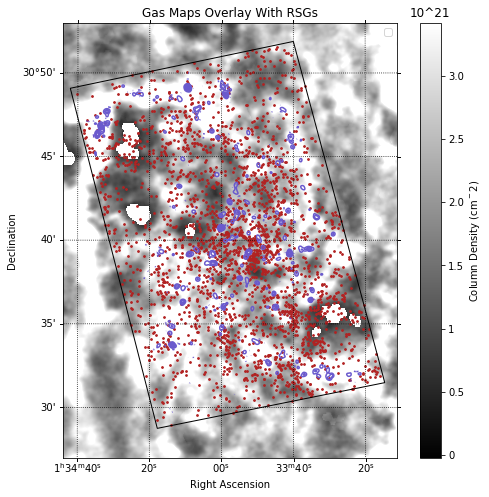

In [26]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from regions import PixCoord, CirclePixelRegion
import matplotlib.pyplot as plt
import sympy
from sympy import init_printing

filename = get_pkg_data_filename('atomic.fits')
hdu = fits.open(filename)[0]
conv_hdu = conv * hdu.data

fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(projection=wc3, label='overlays')

plt.imshow(conv_hdu, cmap='gray',  vmin=-100 * conv, vmax= 560 * conv)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
cbar.set_label('Column Density (cm$^-2$)', rotation=90)
cbar.ax.set_title('10^21')
plt.title('Gas Maps Overlay With RSGs')

ax.coords.grid(True, color='black', ls='dotted')
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
#stars
#ax.scatter(rsgs_inside_box2.ra.deg, rsgs_inside_box2.dec.deg, transform=ax.get_transform('fk5'),  s=3, edgecolor='firebrick', facecolor='firebrick', cmap='gray', label= 'RSGs', color='firebrick')
ax.scatter(rsgs_inside_box1.ra.deg, rsgs_inside_box1.dec.deg, transform=ax.get_transform('fk5'), s=3, edgecolor='firebrick', facecolor='firebrick', cmap='gray')
atomicpixel_region.plot()
#atomicpixel_region2.plot()
ax.contour(comapdata2, transform=ax.get_transform(WCS(comapheader2, naxis=2)), colors='slateblue')
location = 0 # For the best location
legend_drawn_flag = True
plt.legend()
ax.set_xlim(400,800)   
ax.set_ylim(550,1070)

<ipython-input-27-40f8c171db0e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
No handles with labels found to put in legend.


(550.0, 1070.0)

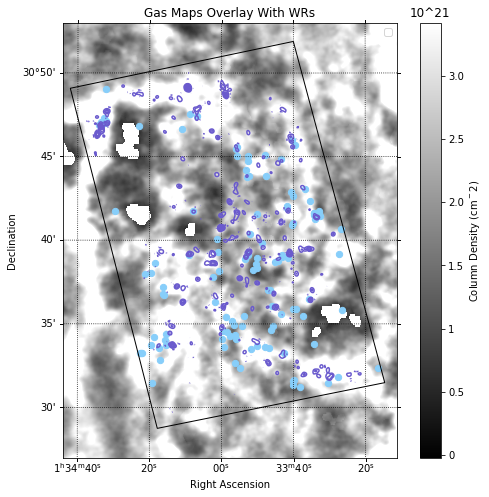

In [27]:
fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(projection=wc3, label='overlays')

plt.imshow(conv_hdu, cmap='gray',  vmin=-100 * conv, vmax= 560 * conv)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
cbar.set_label('Column Density (cm$^-2$)', rotation=90)
cbar.ax.set_title('10^21')
plt.title('Gas Maps Overlay With WRs')

ax.coords.grid(True, color='black', ls='dotted')
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
#stars
#ax.scatter(wrs_inside_box2.ra.deg, wrs_inside_box2.dec.deg, transform=ax.get_transform('fk5'),  s=40, edgecolor='springgreen', facecolor='springgreen', cmap='gray', label= 'WRs', color='springgreen')
ax.scatter(wrs_inside_box1.ra.deg, wrs_inside_box1.dec.deg, transform=ax.get_transform('fk5'), s=40, edgecolor='lightskyblue', facecolor='lightskyblue', cmap='gray')
atomicpixel_region.plot()
#atomicpixel_region2.plot()
ax.contour(comapdata2, transform=ax.get_transform(WCS(comapheader2, naxis=2)), colors='slateblue')
location = 0 # For the best location
legend_drawn_flag = True
plt.legend()
ax.set_xlim(400,800)   
ax.set_ylim(550,1070)

<ipython-input-28-a0dd468a776e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
No handles with labels found to put in legend.


(550.0, 1070.0)

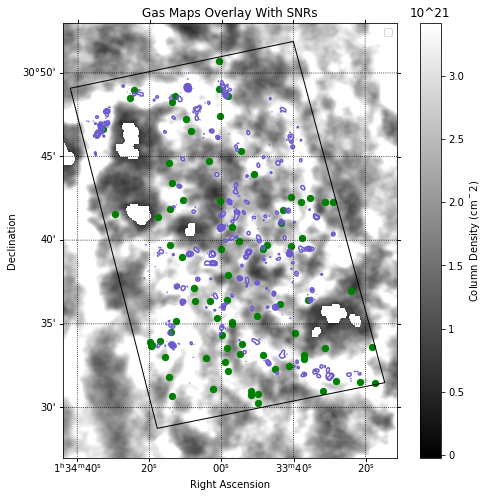

In [28]:
fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(projection=wc3, label='overlays')

plt.imshow(conv_hdu, cmap='gray',  vmin=-100 * conv, vmax= 560 * conv)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
cbar.set_label('Column Density (cm$^-2$)', rotation=90)
cbar.ax.set_title('10^21')
plt.title('Gas Maps Overlay With SNRs')

ax.coords.grid(True, color='black', ls='dotted')
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
#stars
#ax.scatter(snr_inside_box2.ra.deg, snr_inside_box2.dec.deg, transform=ax.get_transform('fk5'),  s=40, edgecolor='mediumblue', facecolor='mediumblue', cmap='gray', label= 'SNRs', color='mediumblue')
ax.scatter(snr_inside_box1.ra.deg, snr_inside_box1.dec.deg, transform=ax.get_transform('fk5'), s=40, edgecolor='green', facecolor='green', cmap='gray')
atomicpixel_region.plot()
#atomicpixel_region2.plot()
ax.contour(comapdata2, transform=ax.get_transform(WCS(comapheader2, naxis=2)), colors='slateblue')
location = 0 # For the best location
legend_drawn_flag = True
plt.legend()
ax.set_xlim(400,800)   
ax.set_ylim(550,1070)

In [29]:
np.nanmin(comapdata2)

-172.9996839467717

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
<ipython-input-30-897e651b22bf>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])


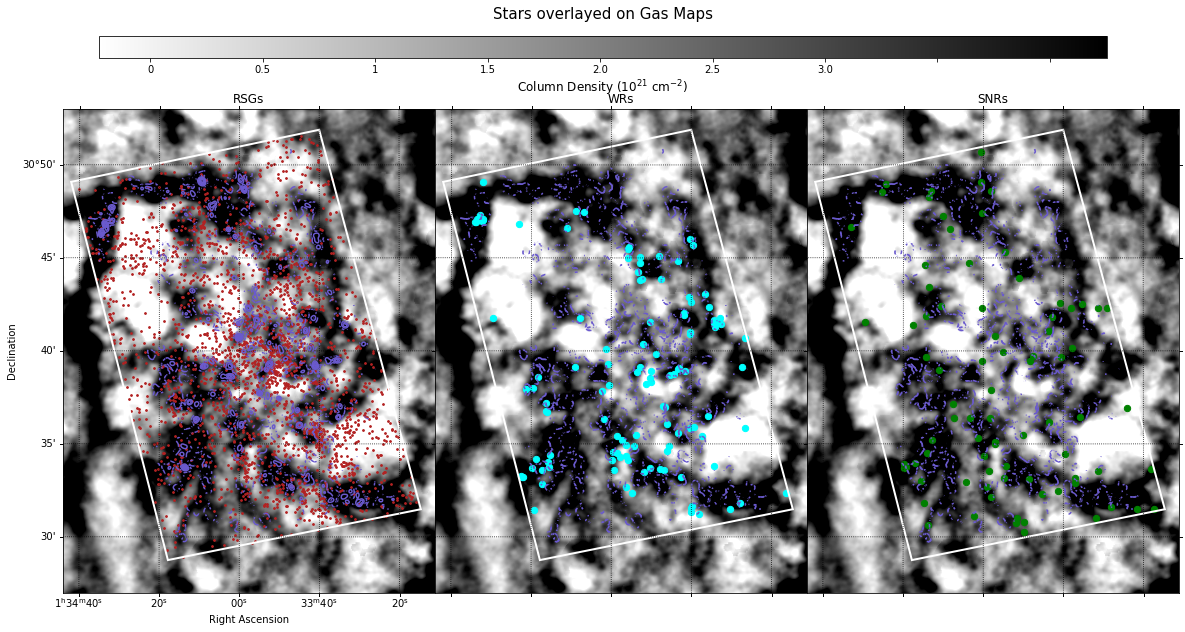

In [30]:
##RSG
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax = plt.subplot(131, projection=wc3, label='overlays')
plt.suptitle('Stars overlayed on Gas Maps', fontsize = 15)

atomicpixel_region.plot(color = 'white', linewidth=2)
ax.contour(comapdata2, vmin = 100, vmax = 23148, levels = [100,
3392.6,
6685.2,
9977.8,
13270.4,
16563,
19855.6,
23148.2,
], transform=ax.get_transform(WCS(comapheader2, naxis=2)), colors='slateblue')
q = ax.imshow(conv_hdu, cmap='gray_r',  vmin=170 * conv, vmax= 600 * conv)
#cax = fig.add_axes([0.95, 0.1, 0.03, 0.6]) #define the location for colorbar 
cax = fig.add_axes([0.15, 0.91, 0.70, 0.03])
cbar = fig.colorbar(q, cax=cax, orientation="horizontal") #define colorbar and include its location
#cbar.set_label("Log # of data points", size=12) #set label of colorbar
cbar.ax.set_xticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
cbar.set_label('Column Density (10$^{21}$ cm$^{-2}$)', size = 12, rotation=0)
#cbar.ax.set_title('10$^{21}$')
ax.set_title('RSGs')

ax.coords.grid(True, color='black', ls='dotted')
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
              
#Stars
#ax.scatter(rsgs_inside_box2.ra.deg, rsgs_inside_box2.dec.deg, transform=ax.get_transform('fk5'),  s=3, edgecolor='firebrick', facecolor='firebrick', cmap='gray', label= 'RSGs', color='firebrick')
ax.scatter(rsgs_inside_box1.ra.deg, rsgs_inside_box1.dec.deg, transform=ax.get_transform('fk5'), s=3, edgecolor='firebrick', facecolor='firebrick', cmap='gray')
#atomicpixel_region2.plot()
#ax.contour(comapdata2, levels = [-172,0,], transform=ax.get_transform(WCS(comapheader2, naxis=2)), colors='slateblue')
#location = 0 # For the best location
#legend_drawn_flag = True
#axs[1].legend()
ax.set_xlim(400,800)   
ax.set_ylim(550,1070)

## WR
ax2 = plt.subplot(132, projection=wc3, label='overlays')
ax2.imshow(conv_hdu, cmap='gray_r',  vmin=170 * conv, vmax= 600 * conv)
#cbar = plt.colorbar()
#cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
#cbar.axs[0].set_label('Column Density (cm$^-2$)', rotation=90)
#cbar.ax.set_title('10^21')
ax2.set_title('WRs')

ax2.coords.grid(True, color='black', ls='dotted')
#ax2.coords[0].set_axislabel('Right Ascension')
#ax2.coords[1].set_axislabel('Declination')
              
#Stars
#ax2.scatter(wrs_inside_box2.ra.deg, wrs_inside_box2.dec.deg, transform=ax2.get_transform('fk5'),  s=40, edgecolor='springgreen', facecolor='springgreen', cmap='gray', label= 'WRs', color='springgreen')
ax2.scatter(wrs_inside_box1.ra.deg, wrs_inside_box1.dec.deg, transform=ax2.get_transform('fk5'), s=40, edgecolor='cyan', facecolor='cyan', cmap='gray')
atomicpixel_region.plot(color = 'white', linewidth=2)
#atomicpixel_region2.plot()
ax2.contour(comapdata2, levels = [50,100,], transform=ax2.get_transform(WCS(comapheader2, naxis=2)), colors='slateblue')
#location = 0 # For the best location
#legend_drawn_flag = True
#axs[1].legend()
ax2.set_xlim(400,800)   
ax2.set_ylim(550,1070)
ax2.coords[0].set_auto_axislabel(False)
ax2.coords[1].set_auto_axislabel(False)
lon = ax2.coords[0]
lat = ax2.coords[1]
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)

ax3 = plt.subplot(133, projection=wc3, label='overlays')
ax3.imshow(conv_hdu, cmap='gray_r',  vmin=170 * conv, vmax= 600 * conv)
#cbar = plt.colorbar()
#cbar.axs[0].set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
#cbar.axs[0].set_label('Column Density (cm$^-2$)', rotation=90)
#cbar.ax.set_title('10^21')
ax3.set_title('SNRs')

ax3.coords.grid(True, color='black', ls='dotted')
#ax3.coords[0].set_axislabel('Right Ascension')
#ax3.coords[1].set_axislabel('Declination')
              
#Stars
#ax3.scatter(snr_inside_box2.ra.deg, snr_inside_box2.dec.deg, transform=ax3.get_transform('fk5'),  s=40, edgecolor='mediumblue', facecolor='mediumblue', cmap='gray', label= 'SNRs', color='mediumblue')
ax3.scatter(snr_inside_box1.ra.deg, snr_inside_box1.dec.deg, transform=ax3.get_transform('fk5'), s=40, edgecolor='green', facecolor='green', cmap='gray')
atomicpixel_region.plot(color = 'white', linewidth=2)
#atomicpixel_region2.plot()
ax3.contour(comapdata2, levels = [50,100,], transform=ax3.get_transform(WCS(comapheader2, naxis=2)), colors='slateblue')
#location = 0 # For the best location
#legend_drawn_flag = True
#axs[1].legend()
ax3.set_xlim(400,800)   
ax3.set_ylim(550,1070)
ax3.coords[0].set_auto_axislabel(False)
ax3.coords[1].set_auto_axislabel(False)
lon2 = ax3.coords[0]
lat2 = ax3.coords[1]
lon2.set_ticklabel_visible(False)
lat2.set_ticklabel_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)

(array([2.07298e+05, 2.89170e+04, 7.19700e+03, 2.43400e+03, 8.93000e+02,
        3.88000e+02, 2.66000e+02, 1.60000e+02, 7.30000e+01, 3.50000e+01]),
 array([ -172.99968395,  2159.12309144,  4491.24586683,  6823.36864222,
         9155.49141761, 11487.614193  , 13819.73696839, 16151.85974378,
        18483.98251917, 20816.10529456, 23148.22806995]),
 <BarContainer object of 10 artists>)

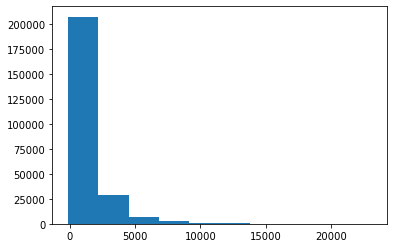

In [31]:
plt.hist(comapdata2.flatten())

## Figure 2

## Graphing our stars and region

## Testing

## Converting Intensity to Column Density

In [32]:
rsg_codense = conv * rsgco
wr_codense = conv * wrco
snr_codense = conv * snrco

#FOR STARS IN REGION
rsg_inside_codense = conv * rsg_inco
wr_inside_codense = conv * wr_inco
snr_inside_codense = conv * snr_inco


rsg_atomicdense = conv * rsgatomic
wr_atomicdense = conv * wratomic
snr_atomicdense = conv * snratomic

In [33]:
rsg_atomic_dens = rsgatomic * conv
rsg_atomic_dens_zeronan = np.nan_to_num(rsg_atomic_dens, copy=True, nan=0.0)
wr_atomic_dens = wratomic * conv
wr_atomic_dens_zeronan = np.nan_to_num(wr_atomic_dens, copy=True, nan=0.0)
snr_atomic_dens = snratomic * conv
snr_atomic_dens_zeronan = np.nan_to_num(snr_atomic_dens, copy=True, nan=0.0)

In [34]:
def hist_weights(x, bins):
    """
    Weights of histogram of data x binned
    into "bins" to normalize peak to 1
    """
    n, _ = np.histogram(x, bins)
    nmax = np.max(n)
    return (np.ones(x.size)*(1/nmax))

Text(0.5, 1.0, 'CO Map')

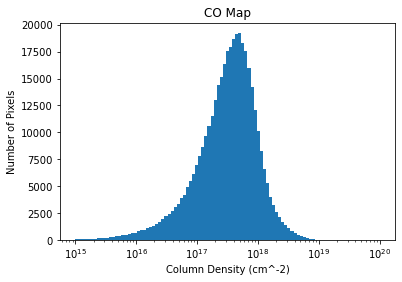

In [35]:
plt.hist(comap_dens.flatten(), bins=np.logspace(15,20,100))
plt.hist(wr_codense, bins=np.logspace(15,20,100), color = 'navy')
plt.xscale('log')
plt.xlabel('Column Density (cm^-2)')
plt.ylabel('Number of Pixels')
plt.title('CO Map')

Text(0.5, 1.0, 'Atomic Map')

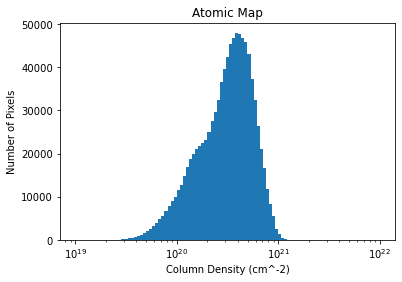

In [36]:
plt.hist(atomic_dens.flatten(), bins=np.logspace(19,22,100))
plt.xscale('log')
plt.xlabel('Column Density (cm^-2)')
plt.ylabel('Number of Pixels')
plt.title('Atomic Map')

Text(0.5, 1.0, 'RSG Pixels on CO Map')

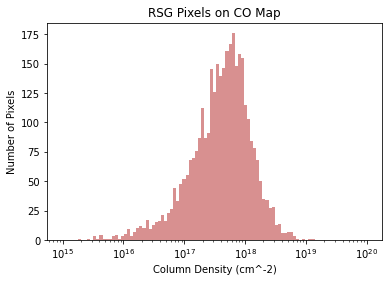

In [37]:
plt.hist(rsg_codense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'firebrick')
#plt.hist(wr_codense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'springgreen')
#plt.hist(snr_codense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'midnightblue')
plt.xscale('log')
plt.xlabel('Column Density (cm^-2)')
plt.ylabel('Number of Pixels')
plt.title('RSG Pixels on CO Map')

### Filter out nans for def statement

In [38]:
rsg_codense_nonan = rsg_codense[~numpy.isnan(rsg_codense)]
wr_codense_nonan = wr_codense[~numpy.isnan(wr_codense)]
snr_codense_nonan = snr_codense[~numpy.isnan(snr_codense)]

rsg_atomicdense_nonan = rsg_atomicdense[~numpy.isnan(rsg_atomicdense)]
wr_atomicdense_nonan = wr_atomicdense[~numpy.isnan(wr_atomicdense)]
snr_atomicdense_nonan = snr_atomicdense[~numpy.isnan(snr_atomicdense)]

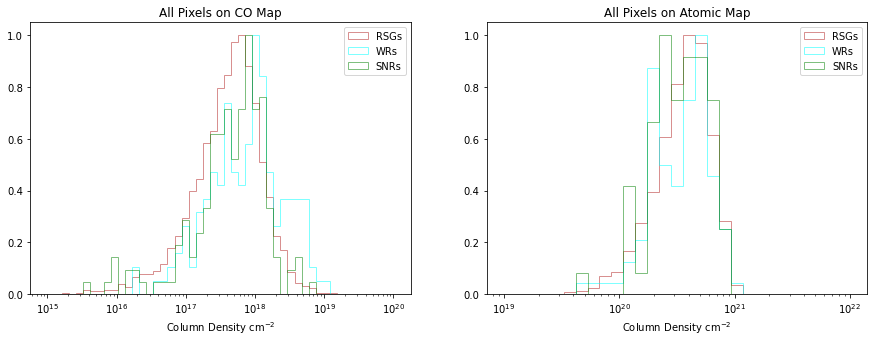

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.logspace(15,20,50)
plt.figure()
ax1.hist(rsg_codense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(rsg_codense_nonan, bins), alpha=0.5, histtype='step', color = 'firebrick', label = 'RSGs')
ax1.hist(wr_codense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(wr_codense_nonan, bins), alpha=0.5, histtype='step', color = 'cyan', label = 'WRs')
ax1.hist(snr_codense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(snr_codense_nonan, bins), alpha=0.5, histtype='step', color = 'green', label = 'SNRs')
ax1.set_title('All Pixels on CO Map')
ax1.set_xlabel("Column Density cm$^{-2}$")
ax1.set_xscale("log")
ax1.legend()

bins = np.logspace(19,22,30)
plt.figure()
ax2.hist(rsg_atomicdense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(rsg_atomicdense_nonan, bins), alpha=0.5, histtype='step', color = 'firebrick', label = 'RSGs')
ax2.hist(wr_atomicdense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(wr_atomicdense_nonan, bins), alpha=0.5, histtype='step', color = 'cyan', label = 'WRs')
ax2.hist(snr_atomicdense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(snr_atomicdense_nonan, bins), alpha=0.5, histtype='step', color = 'green', label = 'SNRs')
ax2.set_title('All Pixels on Atomic Map')
ax2.set_xlabel("Column Density cm$^{-2}$")
ax2.set_xscale("log")
ax2.legend()

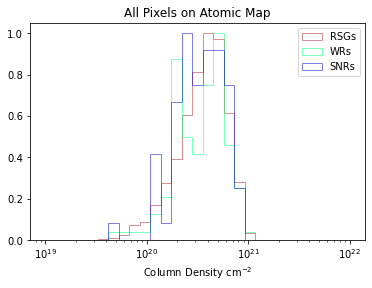

In [40]:
bins = np.logspace(19,22,30)
plt.figure()
plt.hist(rsg_atomicdense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(rsg_atomicdense_nonan, bins), alpha=0.5, histtype='step', color = 'firebrick', label = 'RSGs')
plt.hist(wr_atomicdense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(wr_atomicdense_nonan, bins), alpha=0.5, histtype='step', color = 'springgreen', label = 'WRs')
plt.hist(snr_atomicdense_nonan.flatten(),\
             bins=bins,\
             weights=hist_weights(snr_atomicdense_nonan, bins), alpha=0.5, histtype='step', color = 'mediumblue', label = 'SNRs')
plt.title('All Pixels on Atomic Map')
plt.xlabel("Column Density cm$^{-2}$")
plt.xscale("log")
plt.legend()
plt.show()

Text(0.5, 1.0, 'WR Pixels on CO Map')

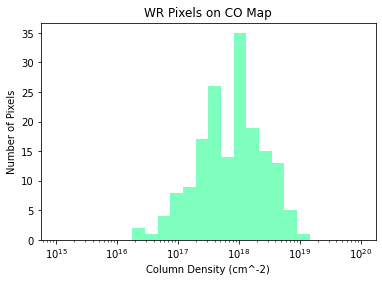

In [41]:
#plt.hist(rsg_codense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'firebrick')
plt.hist(wr_codense, bins=np.logspace(15,20,25), alpha=0.5,  color = 'springgreen')
#plt.hist(snr_codense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'goldenrod')
plt.xscale('log')
plt.xlabel('Column Density (cm^-2)')
plt.ylabel('Number of Pixels')
plt.title('WR Pixels on CO Map')

Text(0.5, 1.0, 'SNR Pixels on CO Map')

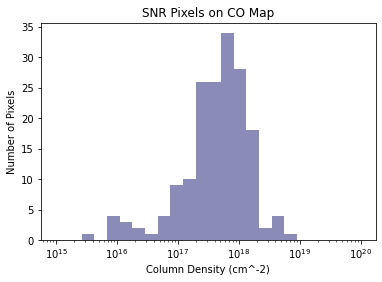

In [42]:
#plt.hist(rsg_codense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'firebrick')
#plt.hist(wr_codense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'springgreen')
plt.hist(snr_codense, bins=np.logspace(15,20,25), alpha=0.5,  color = 'midnightblue')
plt.xscale('log')
plt.xlabel('Column Density (cm^-2)')
plt.ylabel('Number of Pixels')
plt.title('SNR Pixels on CO Map')

Text(0.5, 1.0, 'RSG Pixels on Atomic Map')

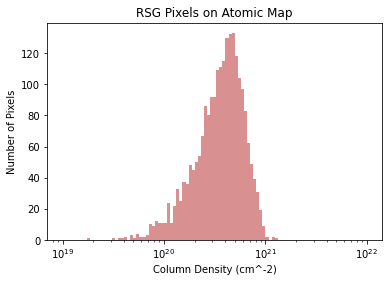

In [43]:
plt.hist(rsg_atomicdense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'firebrick')
#plt.hist(wr_atomicdense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'springgreen')
#plt.hist(snr_atomicdense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'goldenrod')
plt.xscale('log')
plt.xlabel('Column Density (cm^-2)')
plt.ylabel('Number of Pixels')
plt.title('RSG Pixels on Atomic Map')

Text(0.5, 1.0, 'WR Pixels on Atomic Map')

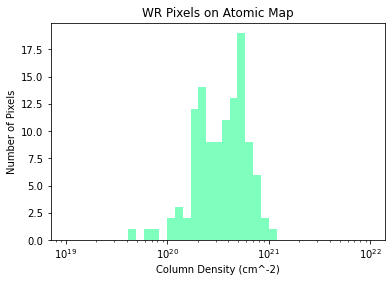

In [44]:
#plt.hist(rsg_atomicdense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'firebrick')
plt.hist(wr_atomicdense, bins=np.logspace(19,22,40), alpha=0.5,  color = 'springgreen')
#plt.hist(snr_atomicdense, bins=np.logspace(15,20,100), alpha=0.5,  color = 'goldenrod')
plt.xscale('log')
plt.xlabel('Column Density (cm^-2)')
plt.ylabel('Number of Pixels')
plt.title('WR Pixels on Atomic Map')

Text(0.5, 1.0, 'SNR Pixels on Atomic Map')

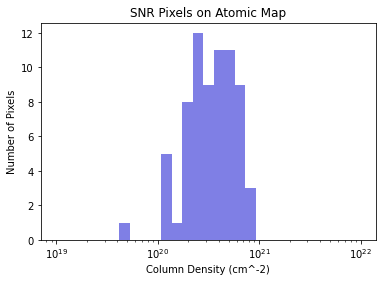

In [45]:
#plt.hist(rsg_atomicdense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'firebrick')
#plt.hist(wr_atomicdense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'springgreen')
plt.hist(snr_atomicdense, bins=np.logspace(19,22,30), alpha=0.5,  color = 'mediumblue')
plt.xscale('log')
plt.xlabel('Column Density (cm^-2)')
plt.ylabel('Number of Pixels')
plt.title('SNR Pixels on Atomic Map')

## Figure 3

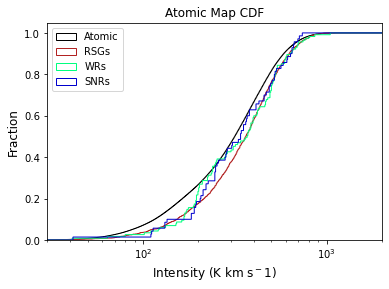

In [46]:
plt.figure()
plt.hist(sorted_atomicmap_nozeros, histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="Atomic")
plt.hist(rsgatomic, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="RSGs")
plt.hist(wratomic, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="WRs")
plt.hist(snratomic, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="SNRs")
plt.title('Atomic Map CDF')
plt.xlabel("Intensity (K km s$^-1$)", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(30, 2000)
plt.legend(loc=2)
plt.show()

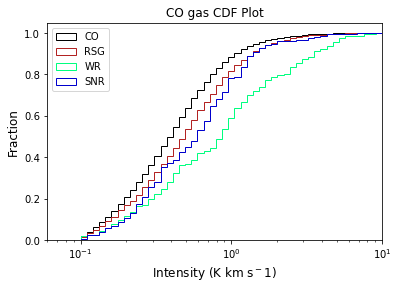

In [47]:
plt.figure()
plt.hist(comapdata.flatten(), histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="CO")
plt.hist(rsgco, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="RSG")
plt.hist(wrco, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="WR")
plt.hist(snrco, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="SNR")
plt.title('CO Map CDF')
plt.xlabel("Intensity (K km s$^-1$)", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(0.06, 10)
plt.legend(loc=2)
plt.title('CO gas CDF Plot')
plt.show()

# FOR STARS INSIDE REGION

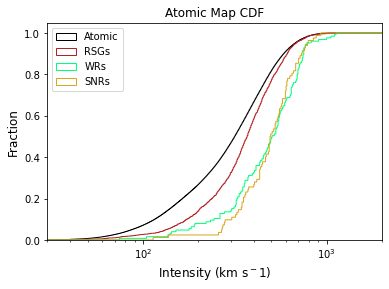

In [48]:
plt.figure()
plt.hist(sorted_atomicmap_nozeros, histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="Atomic")
plt.hist(rsg_inat, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="RSGs")
plt.hist(wr_inat, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="WRs")
plt.hist(snr_inat, histtype="step", color="goldenrod", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="SNRs")
plt.title('Atomic Map CDF')
plt.xlabel("Intensity (km s$^-1$)", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(30, 2000)
plt.legend(loc=2)
plt.show()

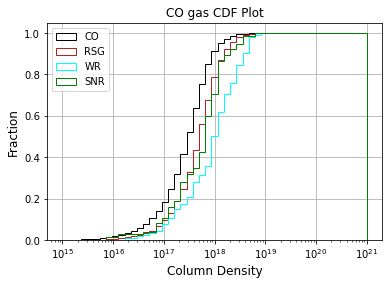

In [49]:
plt.figure()
plt.hist(comapdata.flatten() * conv, histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(15, 21, 50), label="CO")
plt.hist(rsg_inco *conv, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(15, 21, 50), label="RSG")
plt.hist(wr_inco * conv, histtype="step", color="cyan", \
         density=True, cumulative=True, bins=np.logspace(15, 21, 50), label="WR")
plt.hist(snr_inco * conv, histtype="step", color="green", \
         density=True, cumulative=True, bins=np.logspace(15, 21, 50), label="SNR")
plt.title('CO Map CDF')
plt.xlabel("Column Density", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
#plt.xlim(0, 10)
plt.legend(loc=2)
plt.title('CO gas CDF Plot')
plt.grid()
plt.show()

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


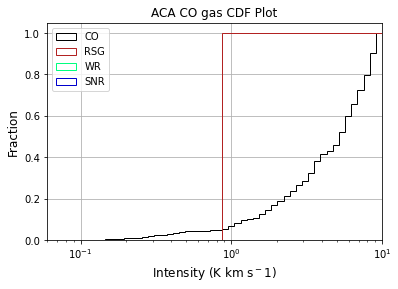

In [50]:
plt.figure()
plt.hist(comapdata2.flatten(), histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="CO")
plt.hist(rsg_inco2, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="RSG")
plt.hist(wr_inco2, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="WR")
plt.hist(snr_inco2, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="SNR")
plt.title('CO Map CDF')
plt.xlabel("Intensity (K km s$^-1$)", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(0.06, 10)
plt.legend(loc=2)
plt.title('ACA CO gas CDF Plot')
plt.grid()
plt.show()

## Figure 4

In [51]:
#Ness CO Data
ncr_type1a = np.array([0, 0, 0, 0, 0, 0, 0, 0.05, 0.65, 0.73, 0.83, 0.89])
ncr_type2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05, 0.1, 0.1, 0.18, 0.29, 0.37, 0.41, 0.68, 0.7, 0.72, 0.76, 0.81, 0.83, 0.9, 0.93, 0.98, 0.98, 0.99, 1])
ncr_sesn = np.array([0, 0.2, 0.24, 0.75, 0.92, 0.95, 0.98, 1])
ncr_unclassified = np.array([0, 0.56, 0.91, 0.92, 0.96, 0.99, 0.99])
ncr_all = np.sort(np.concatenate((ncr_type1a, ncr_type2, ncr_sesn, ncr_unclassified)))

In [52]:
comap_zeronans = np.nan_to_num(comapdata.flatten(), copy=True, nan=0.0)
sorted_comap_zeronans = np.sort(comap_zeronans)

filter_arr = []

for element in sorted_comap_zeronans:

  if element > 0:
    filter_arr.append(True)
  else:
    filter_arr.append(False)
    
sorted_comap_nozeros = sorted_comap_zeronans[filter_arr]
# Getting NCRs
ncr_snrco = get_ncr(sorted_comap_nozeros, snrco)
ncr_WR = get_ncr(sorted_comap_nozeros, wrco)
ncr_RSG = get_ncr(sorted_comap_nozeros, rsgco)

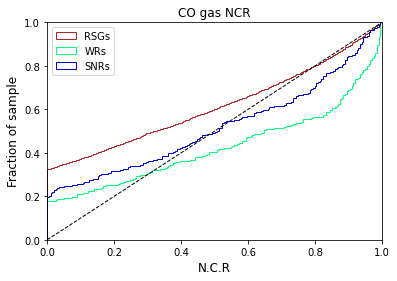

In [53]:
plt.figure()
plt.hist(ncr_RSG, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs")
plt.hist(ncr_WR, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRs")
plt.hist(ncr_snrco, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SNRs")
#plt.hist(ncr_type1a, histtype="step", color="cyan", \
         #density=True, cumulative=True, bins=np.linspace(0,1,200), label="Type 1a")
#plt.hist(ncr_type2, histtype="step", color="orange", \
         #density=True, cumulative=True, bins=np.linspace(0,1,200), label="Type 2")
#plt.hist(ncr_sesn, histtype="step", color="magenta", \
         #density=True, cumulative=True, bins=np.linspace(0,1,200), label="SESN")
#plt.hist(ncr_unclassified, histtype="step", color="yellow", \
         #density=True, cumulative=True, bins=np.linspace(0,1,200), label="Unclassified")


plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('CO gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)#, prop={'size': 7})
plt.show()

In [54]:
ncr_WRco_inside = get_ncr(sorted_comap_zeronans, wr_inco)
ncr_RSGco_inside = get_ncr(sorted_comap_zeronans, rsg_inco)
ncr_snrco_inside = get_ncr(sorted_comap_zeronans, snr_inco)

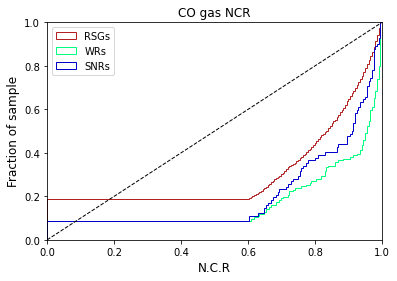

In [55]:
plt.figure()
plt.hist(ncr_RSGco_inside, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs")
plt.hist(ncr_WRco_inside, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRs")
plt.hist(ncr_snrco_inside, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SNRs")
#plt.hist(ncr_type1a, histtype="step", color="cyan", \
         #density=True, cumulative=True, bins=np.linspace(0,1,200), label="Type 1a")
#plt.hist(ncr_type2, histtype="step", color="orange", \
         #density=True, cumulative=True, bins=np.linspace(0,1,200), label="Type 2")
#plt.hist(ncr_sesn, histtype="step", color="magenta", \
         #density=True, cumulative=True, bins=np.linspace(0,1,200), label="SESN")
#plt.hist(ncr_unclassified, histtype="step", color="yellow", \
         #density=True, cumulative=True, bins=np.linspace(0,1,200), label="Unclassified")


plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('CO gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)#, prop={'size': 7})
plt.show()

In [56]:
wrpix_insideatomic = np.array([[i,j] for i,j in wrpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
rsgpix_insideatomic = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
snrpix_insideatomic = np.array([[i,j] for i,j in snrpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T

wratomic = atomicmapdata[wrpix_insideatomic[1], wrpix_insideatomic[0]]
rsgatomic = atomicmapdata[rsgpix_insideatomic[1], rsgpix_insideatomic[0]]
snratomic = atomicmapdata[snrpix_insideatomic[1], snrpix_insideatomic[0]]

atomicmap_zeronans = np.nan_to_num(atomicmapdata.flatten(), copy=True, nan=0.0)
sorted_atomicmap_zeronans = np.sort(atomicmap_zeronans)

filter_arr2 = []

for element in sorted_atomicmap_zeronans:

  if element > 0:
    filter_arr2.append(True)
  else:
    filter_arr2.append(False)
    
sorted_atomicmap_nozeros = sorted_atomicmap_zeronans[filter_arr2]

#Getting NCR
ncr_WRatomic = get_ncr(sorted_atomicmap_nozeros, wratomic)
ncr_RSGatomic = get_ncr(sorted_atomicmap_nozeros, rsgatomic)
ncr_snratomic = get_ncr(sorted_atomicmap_nozeros, snratomic)


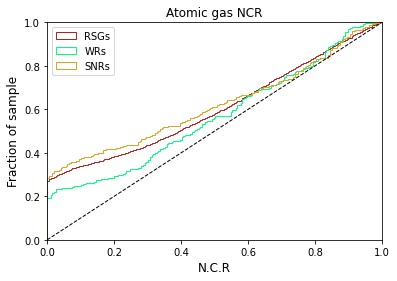

In [57]:
plt.figure()
plt.hist(ncr_RSGatomic, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs")
plt.hist(ncr_WRatomic, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRs")
plt.hist(ncr_snratomic, histtype="step", color="goldenrod", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SNRs")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('Atomic gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()

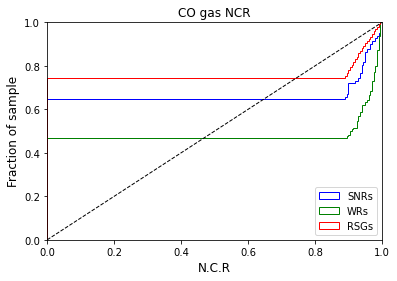

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


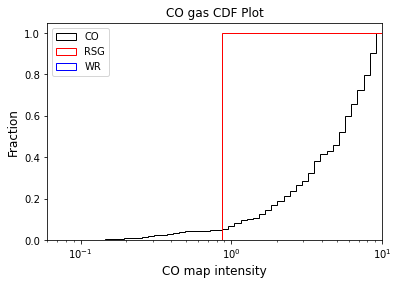

In [58]:
plt.figure()
plt.hist(ncr_snrco2, histtype="step", color="blue", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SNRs")
plt.hist(ncr_WRco2, histtype="step", color="green", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRs")
plt.hist(ncr_RSGco2, histtype="step", color="red", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('CO gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=4)
plt.show()

#CDF PLOT
plt.figure()
plt.hist(sorted_comap2_zeronans, histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="CO")
plt.hist(rsgco2, histtype="step", color="red", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="RSG")
plt.hist(wrco2, histtype="step", color="blue", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="WR")
plt.xlabel("CO map intensity", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(0.06, 10)
plt.legend(loc=2)
plt.title('CO gas CDF Plot')
plt.show()